In [2]:
%load_ext tensorboard

%run setup/GpuOptions.ipynb

import os
import sys
import logging

'..' not in sys.path and sys.path.append('..')
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import importlib
import tensorflow as tf
from datetime import datetime
from common import frozenmodel
from common.dataset import Dataset
from tensorflow.keras import callbacks, optimizers, losses
importlib.reload(frozenmodel)

dataset = Dataset(
    '../dataset/dataset-2023-05-14T20-52-55',
    batch_size=10,
    image_size=(1080, 1920))

model = frozenmodel.generate_model(
    weights_filepath='isthemountainout.best.h5',
    with_augmentations=True,
    can_ignore_weights=True)
model.compile(
    optimizer=optimizers.Adadelta(
        learning_rate=optimizers.schedules.CosineDecayRestarts(
            2.5,
            # Decay over 5 epochs and then restart 
            dataset.training.cardinality().numpy() * 10)),
    loss=losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.08),
    metrics=['accuracy'],
)
model.fit(
    dataset.training,
    epochs=700,
    verbose=True,
    validation_data=dataset.validation,
    callbacks=[
        callbacks.TensorBoard(
            log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")),
        tf.keras.callbacks.ModelCheckpoint(
            'isthemountainout.best.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=True),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=100,
            restore_best_weights=True,
            verbose=True),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join('tensor-logs', 'fit', datetime.now().strftime('%Y%m%d%H%M%S')),
            update_freq=50,
            write_images=True,
            write_graph=True,
            embeddings_freq=10),
    ])

GPU Available: True
Enabling memory growth on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 11704 files belonging to 4 classes.
Using 9364 files for training.
Found 11704 files belonging to 4 classes.
Using 2340 files for validation.
Epoch 1/700
937/937 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8739
Epoch 1: val_loss improved from inf to 0.39573, saving model to isthemountainout.best.h5
937/937 [==============================] - 401s 420ms/step - loss: 0.5281 - accuracy: 0.8739 - val_loss: 0.3957 - val_accuracy: 0.9581
Epoch 2/700
937/937 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8780
Epoch 2: val_loss did not improve from 0.39573
937/937 [==============================] - 395s 421ms/step - loss: 0.5203 - accuracy: 0.8780 - val_loss: 0.4085 - val_accuracy: 0.9509
Epoch 3/700
937/937 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.8837
Epoch 3: val_loss did not improve from 0.395

GPU Available: True
Enabling memory growth on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
loading model with best weights
Found 11704 files belonging to 4 classes.
Using 8193 files for training.
Found 11704 files belonging to 4 classes.
Using 3511 files for validation.


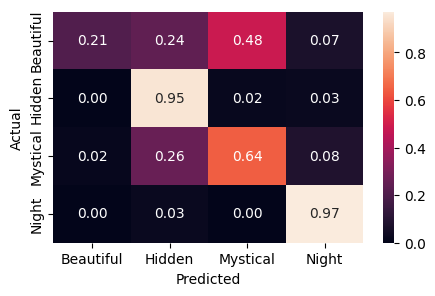

In [1]:
%run setup/GpuOptions.ipynb

import os
import sys
import logging

'..' not in sys.path and sys.path.append('..')
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import importlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from common import frozenmodel
from common.dataset import Dataset
importlib.reload(frozenmodel)

print('loading model with best weights')
# from common.weights import weights
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../isthemountainout-credentials.json'
# with weights() as filename:
model = frozenmodel.generate_model(
    weights_filepath='isthemountainout.h5', # filename
    with_augmentations=True)

dataset = Dataset(
    '../dataset/dataset-2023-05-14T20-52-55',
    batch_size=3,
    image_size=(1080, 1920),
    validation_split=0.3)
validations = dataset.validation
predictions = []
labels = []
for data, label in validations:
  labels.append(tf.argmax(label, axis=1))
  predictions.append(tf.math.argmax(tf.nn.softmax(model.predict(data, verbose=0)), axis=1))
labels = tf.concat(labels, axis=0)
predictions = tf.concat(predictions, axis=0)
cm = confusion_matrix(labels, predictions, labels=list(range(len(dataset.validation.class_names))))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(
  cmn,
  annot=True,
  fmt='.2f',
  xticklabels=dataset.validation.class_names,
  yticklabels=dataset.validation.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)